In [ ]:
import os, time
import numpy as np
import pickle

# RNN model and task
from model import RNN, run_net
from task_generators import auto_cos
task_generator = auto_cos

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import style
from fig_specs import *
save_fig=True

# Data directory 
from data_dir import data_dir
data_file_name = "cos_zhat_10_gs_same_wio_N_256.pkl"
data_file = os.path.join(data_dir, data_file_name)

In [2]:
# Load data
print("data_file_name:\n", data_file_name)
with open(data_file, 'rb') as handle:
    res_dict = pickle.load(handle)
print("Loaded data from " + data_file)

dims = res_dict["dims"]
dt = res_dict["dt"]
noise_std = res_dict["noise_std"]
n_epochs = res_dict["n_epochs"]
rec_step = res_dict["rec_step"]
epochs = res_dict["epochs"]
rec_epochs = res_dict["rec_epochs"]
gs = res_dict["gs"]
target_amps = res_dict["target_amps"]
# lr0s = res_dict["lr0s"]
n_gs = res_dict["n_gs"]
n_tas = res_dict["n_tas"]
n_samples = res_dict["n_samples"]
lrs_all = res_dict["lrs_all"]
tls_all = res_dict["tls_all"]
task_params_all = res_dict["task_params_all"]
wi_init_all = res_dict["wi_init_all"]
wo_init_all = res_dict["wo_init_all"]
wrec_init_all = res_dict["wrec_init_all"]
dwrec_last_all = res_dict["dwrec_last_all"]
losses_all = res_dict["losses_all"]
grad_norms_all = res_dict["grad_norms_all"]
loss_shuff_all = res_dict["loss_shuff_all"]
ev_w_all = res_dict["ev_w_all"]
sv_dw_all = res_dict["sv_dw_all"]
zs_all = res_dict["zs_all"]
time_t = res_dict["time_t"]
time_ev = res_dict["time_ev"]
time_sv = res_dict["time_sv"]
time_ls = res_dict["time_ls"]

if "nonlin" in data_file_name:
    nonlinearity = "tanh"
else:
    nonlinearity = "id"
    
dim_in, dim_rec, dim_out = dims

data_file_name:
 cos_zhat_10_gs_same_wio_N_256.pkl
Loaded data from ..\..\data\neurips_2020\cos_zhat_10_gs_same_wio_N_256.pkl


In [3]:
# Plot specs
# Choose what to plot
idx_sample = 0
idx_tas_plt = [0]
idx_gs_plt = [0, 1, 2]

In [4]:
task_explain_tas_gs = []
for idx_ta in idx_tas_plt:
    # Task
    task_params_plt = task_params_all[idx_ta]
    task_plt, ts_plt = task_generator(dims, dt, 
                 return_ts=True,
                 **task_params_plt)
    target_amp = target_amps[idx_ta]
    
    task_explain_gs = []
    for idx_g in idx_gs_plt:
        # Plot network activity after training
        g = gs[idx_g]
        wi_init = wi_init_all[idx_sample, idx_ta, idx_g]
        wo_init = wo_init_all[idx_sample, idx_ta, idx_g]
        wrec_init = wrec_init_all[idx_sample, idx_ta, idx_g]
        dwrec_last = dwrec_last_all[idx_sample, idx_ta, idx_g]
        wrec = wrec_init + dwrec_last
        # Run network
        h0_init = wi_init[0]
        net_plt = RNN(dims, noise_std, dt, nonlinearity=nonlinearity, 
                      g=None, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec, h0_init=h0_init)
        res_plt = run_net(net_plt, task_plt, batch_size=1, h_init=h0_init)
        u, y, mask, z, loss = res_plt
        task_explain_g = (target_amp, g, ts_plt, u, y, mask, z)
        task_explain_gs.append(task_explain_g)
        
    task_explain_tas_gs.append(task_explain_gs)

In [5]:
# Explain tasks
# xlim
x0f = 0.05

def plot_cos_explain(fig, axes, task_explain_tas_gs, task_params, x1f=1.5):
    ax0, = axes
    # Task parameters
    t_max = task_params["t_max"]
    target_amp = task_params["target_amp"]
    
    # Batch for explain_task
    batch_idx = 0

    # Input 
    target_amp, g, ts_plt, u, y, mask, z = task_explain_tas_gs[0][0]
    
    for j, task_explain_gs in enumerate(task_explain_tas_gs):
        
        #) Output
        for i, task_explain_g in enumerate(task_explain_gs):
            c = cs[i, 1]
            target_amp, g, ts_plt, u, y, mask, z = task_explain_g
            ax0.plot(ts_plt, z[batch_idx, :, 0], lw=lw, c=c, label="$%.1f$" % (g))
        
        # Target
        m = np.bool_(mask[batch_idx, :, 0])
        z_hat = y[batch_idx, :, 0]
        ax0.plot(ts_plt, z_hat, '--', lw=lw, c='0.4', zorder=10, label="$\hat{z}$")
            
    # Task times
    dt = ts_plt[1] - ts_plt[0]
    t_max_plt = ts_plt[-1] + dt
    # xlim
    x0 = -t_max_plt * x0f
    x1a = t_max_plt * (1 + x0f)
    x1b = t_max_plt * x1f

    ax0.set_ylabel("Output")
    ax0.set_yticks([-1, 0, 1])
    ax0.set_ylim(-1.3, 1.3)
    

    for i, ax in enumerate(axes):
        ax.plot([x0, x1a], [0, 0], '-', c='0.7', zorder=-1)
        ax.set_xlim(x0, x1b)
        ax.set_xticks([0, (t_max-1)//2, t_max-1])
     
    ax0.set_xlabel("Trial time $t$")
    ax0.set_xticklabels([0, "", "$T = %d$" % (t_max)])
    
    ax0.legend(loc=1, frameon=False, framealpha=1., labelspacing=0.1, handlelength=1.5,
               title="$g$", title_fontsize=fs)
    
# Plot loss and eigenvalues
def plot_loss_evs(fig, axes):
    ax0, ax1, ax2 = axes

    idx_sample = 0

    for j in range(n_tas):
        for idx_i, i in enumerate(idx_gs_plt):
            g = gs[i]
            lr = lrs_all[j, i]
            c=cs[idx_i, 1]

            tls = epochs# * lr
            rec_tls = rec_epochs# * lr

            # Loss
            loss_0 = losses_all[idx_sample, j, i, 0]
            ax0.plot(tls, losses_all[idx_sample, j, i] / loss_0, '-', c=c, lw=lw, label="%.1f" % g)

            # Eigenvalues
            ev_w = ev_w_all[idx_sample, j, i]
            # Max imaginary EV
            imis = np.argmax(ev_w.imag, axis=1)
            max_imag_evs = np.array([ev_w[i, imi] for i, imi in enumerate(imis)])

            # Imaginary parts
            ax1.plot(rec_tls, max_imag_evs.imag, '-', c=c, lw=lw)
#             ax1.plot(rec_tls, ev_w[:, 0].imag, '--', c=c, lw=lw, alpha=0.6)

            # Real parts
            ax2.plot(rec_tls, max_imag_evs.real, '-', c=c, lw=lw)
            ax2.plot(rec_tls, ev_w[:, 0].real, '--', c=c, lw=lw, alpha=0.6)


    ax0.axhline(0, ls='-', c='0.7', zorder=-1)
    ax0.set_ylim(-0.05, 1.25)

    ax1.axhline(0, ls='-', c='0.7', zorder=-1)
    ax1.axhline(1, ls='--', c='0.7', zorder=-1)

    ax0.legend(loc=1, 
               handlelength=0.9, labelspacing=0.1,
               frameon=True, framealpha=0.7,
               title="$g$", title_fontsize=fs)

    for i, ax in enumerate(axes):
        ax.set_xticks([0, n_epochs//2, n_epochs])
        if not i == 2:
            ax.set_xticklabels([])

    if j == 0:
        ax0.set_ylabel("Loss")
        ax1.set_ylabel("$\Im(\lambda^{(1)})$")
        ax2.set_ylabel("$\Re(\lambda^{(1)})$")
    else:
        ax0.set_yticklabels([])
        ax1.set_yticklabels([])

    ax2.set_xlabel(r"Epochs")
   

Save figure to ../../tex/neurips_2020/submission_2/figures\cos_loss_evs.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\cos_loss_evs.png


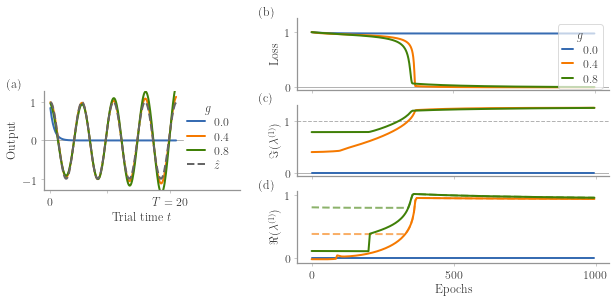

In [6]:
# Explain task and loss
fig = plt.figure(figsize=(fig_width, 0.7 * fig_height))

# Explain task
gs0 = GridSpec(1, 1)
gs0.update(left=0.01, right=0.35, bottom=0.3, top=0.7, wspace=0.0, hspace=0.1)
axes_explain = [plt.subplot(gs0[0, 0])]
plot_cos_explain(fig, axes_explain, task_explain_tas_gs, task_params_plt)

# Loss and SVs over training
gs0 = GridSpec(3, 1)
gs0.update(left=0.45, right=0.99, bottom=0.01, top=0.99, wspace=0.25, hspace=0.2)
axes_loss_evs = np.array([plt.subplot(gs0[j, 0]) for j in range(3)])
plot_loss_evs(fig, axes_loss_evs)

# Label plots
ypos = 1.
ax_idxs = [0, 1, 2, 3]
for i, ax_idx in enumerate(ax_idxs):
    ax = fig.axes[ax_idx]
    if i==0:
        xpos = -0.15
    else:
        xpos = -0.10
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)

style.fixticks(fig)
fig_name = "cos_loss_evs"
if not nonlinearity == 'id':
    fig_name += "_nonlin"
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
    style.saving_fig(fig, figure_path, fig_name, 'png')
plt.show(fig)
plt.close(fig)

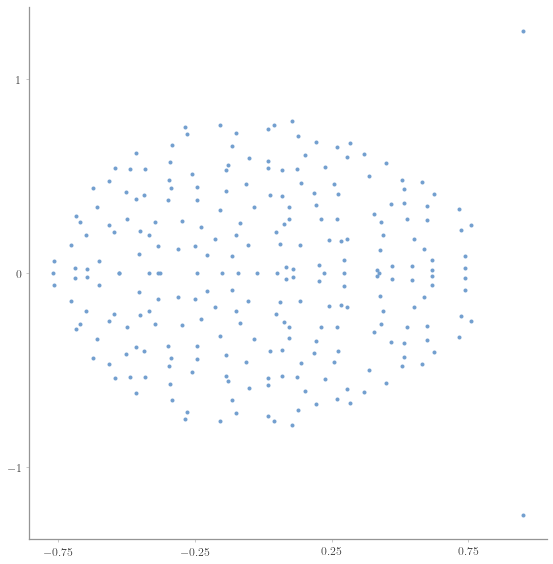

In [7]:
# Plot spectrum at the end of training
fig = plt.figure(figsize=(8, 8))
ax0 = fig.subplots(1, 1)
k=0
j=0
i=2
evs = ev_w_all[k, j, i, -1]
c = cs[j, i]
ax0.plot(evs.real, evs.imag, 'o', c=c)
fig.tight_layout()
style.fixticks(fig)
plt.show(fig)
plt.close(fig)
